In [1]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(lubridate)
library(dplyr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Predicting Subscription Accuracy Based on Player Characteristics and Behaviour

## Background
In the world of digital gaming, user engagement extends beyond gameplay to include interactions such as subscribing to game-related newsletters. Understanding factors, such as gamer’s experience, age, gender, hours played gaming, average gaming session length, and the number of sessions played can help game developers tailor their marketing strategies and improve user retention. The goal of this project aims to determine whether player demographics and behavioural patterns can be used to accurately predict gaming newsletter subscription. 


## Question
Can player characteristics (experience, Age, gender, and played_hours) and in-game behaviours (avg_session_length_min and num_sessions) accurately predict newsletter subscription in a game user dataset? 

Read in the `players.csv` data using `read_csv()` and assign it to an object called players. The data is located within the data/ folder.


In [24]:
players <- read_csv("Data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## Data Description 
To answer the above question, two datasets are used (second data set is found after the next code cell): 

1.	`players.csv`: contains each player’s demographic information and gaming history

|   Variable   	|     Type      |                                                Description                                                   |
|:--------------| :-----------: | -------------------------------------------------------------------------------------------------------:     |
|experience     |Character <chr>| Experience level of the player                                                                               |
|subscribe      |Logical <lgl>  | Whether the player subscribed to the newsletter (TRUE or FALSE)                                              |
|hashedEmail    |Character <chr | Hashed identifier for a unique user, providing anonymity while allowing us to link sessions to the same user |
|played_hours   |Double <dbl>   | Total hours the player has played for                                                                        |
|name           |Character <chr | Name of the player                                                                                           |
|gender         |Character <chr | Gender identity                                                                                              |
|Age            |Double <dbl>   | Age of the player                                                                                            |

- The data above includes 196 rows and 7 columns 

- The number of variables comes out to a total of 7 

## Data Issues 

•	Some variables contain NA values 

•	The gender variable contains additional categories outside of male and female – needs to be handled using an additional function (seen in the preprocessing steps in later code cells)


Read in the `sessions.csv` data using `read_csv()` and assign it to an object called sessions. The data is located within the data/ folder.

In [25]:
sessions <- read_csv("Data/sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


## Data Description 
To answer the above question, two datasets are used:

2.	`sessions.csv`: contains detailed records of individual gameplay sessions – users are identified based on the hashed e-mail they provide

|      Variable   	  |     Type       |                                             Description                                                      |
|:------------------- | :-----------:  | -----------------------------------------------------------------------------------------------------------: |
|hashedEmail          |Character <chr> | Hashed identifier for a unique user, providing anonymity while allowing us to link sessions to the same user |
|start_time           |Character <chr> | The local time when the session started (format: “dd/mm/yyyy hh:mm”)                                         |
|end_time             |Character <chr> | The local time when the session ended (format: “dd/mm/yyyy hh:mm”)                                           |
|original_start_time  |Double <dbl>    | A UNIX timestamp (in milliseconds) representing the original time the session began                          |
|original_end_time    |Double <dbl>    | A UNIX timestamp (in milliseconds) representing the original time the session ended                          |

•	Includes 1535 rows and 5 columns

•	Number of variables: 5

## Data Issues: 
•	Some variables contain missing values (left blank)



Merge the datasets on **hashedEmail** using the `inner_join()` function. This is useful for combining player characteristics with their session data, which is essential to analyze how player behaviour (from `sessions.csv`) relates to subscription status (from `players.csv`).

In [26]:
merged_data <- inner_join(players, sessions, by = "hashedEmail")
merged_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,original_start_time,original_end_time
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,08/08/2024 00:21,08/08/2024 01:35,1.72308e+12,1.72308e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,09/09/2024 22:30,09/09/2024 22:37,1.72592e+12,1.72592e+12
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,08/08/2024 02:41,08/08/2024 03:25,1.72308e+12,1.72309e+12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,23/08/2024 21:39,23/08/2024 21:53,1.72445e+12,1.72445e+12
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,08/09/2024 19:40,08/09/2024 19:45,1.72582e+12,1.72582e+12
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,08/05/2024 19:29,08/05/2024 19:44,1.71520e+12,1.71520e+12


View your new data frame, by using the `glimpse()` function.
Then, convert the time strings to datetime objects (*dmy_hm*) and calculate session length in minutes (`session_length_min`) by using the `mutate()` function.
Label your object name `merged_data_1`. 

In [27]:
glimpse(merged_data)

Rows: 1,535
Columns: 11
$ experience          <chr> "Pro", "Pro", "Pro", "Pro", "Pro", "Pro", "Pro", "…
$ subscribe           <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ hashedEmail         <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0e…
$ played_hours        <dbl> 30.3, 30.3, 30.3, 30.3, 30.3, 30.3, 30.3, 30.3, 30…
$ name                <chr> "Morgan", "Morgan", "Morgan", "Morgan", "Morgan", …
$ gender              <chr> "Male", "Male", "Male", "Male", "Male", "Male", "M…
$ Age                 <dbl> 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,…
$ start_time          <chr> "08/08/2024 00:21", "09/09/2024 22:30", "08/08/202…
$ end_time            <chr> "08/08/2024 01:35", "09/09/2024 22:37", "08/08/202…
$ original_start_time <dbl> 1.72308e+12, 1.72592e+12, 1.72308e+12, 1.72598e+12…
$ original_end_time   <dbl> 1.72308e+12, 1.72592e+12, 1.72309e+12, 1.72598e+12…


In [28]:
merged_data_1 <-  merged_data |>
  mutate(
    start_time = dmy_hm(start_time), # parse start time
    end_time = dmy_hm(end_time), # parse end time
    session_length_min = as.numeric(difftime(end_time, start_time, units = "mins")) # session duration in minutes  
  )
merged_data_1

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,original_start_time,original_end_time,session_length_min
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,1.72308e+12,1.72308e+12,74
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,1.72592e+12,1.72592e+12,7
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,1.72308e+12,1.72309e+12,44
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,2024-08-23 21:39:00,2024-08-23 21:53:00,1.72445e+12,1.72445e+12,14
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,2024-09-08 19:40:00,2024-09-08 19:45:00,1.72582e+12,1.72582e+12,5
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,2024-05-08 19:29:00,2024-05-08 19:44:00,1.71520e+12,1.71520e+12,15


Compute the average session length and group the total number of sessions per player using the `group_by()` and `summarize()` functions. Label the object name as `session_summary`. Next, add the session level summary back to player dataset. Label this object name as `player_data`. 

In [29]:
# Aggregate session info per player
session_summary <- merged_data_1 |>
  group_by(hashedEmail) |>
  summarize(avg_session_length_min = mean(session_length_min, na.rm = TRUE), 
  num_sessions = n()
  )
session_summary

# Merge session summary back to player-level data
player_data <- inner_join(players, session_summary, by = "hashedEmail")
player_data

hashedEmail,avg_session_length_min,num_sessions
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11,1
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9.00000,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72.00000,1


experience,subscribe,hashedEmail,played_hours,name,gender,Age,avg_session_length_min,num_sessions
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,5.00000,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,29.83333,6
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,15.00000,1


Only keep the relevant columns (the predictors and response variable) and remove any rows with missing data using the `drop_na()` function. Name the dataset needed for the planned analysis as `model_data`. 

In [30]:
model_data <- player_data |>
  select(subscribe, experience, played_hours, Age, gender, avg_session_length_min, num_sessions) |>
  drop_na()
model_data

subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<lgl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,Veteran,3.8,17,Male,85.00000,3
FALSE,Veteran,0.0,17,Male,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,Veteran,0.3,22,Male,21.00000,1
FALSE,Amateur,0.0,17,Prefer not to say,5.00000,1
FALSE,Amateur,2.3,17,Male,29.83333,6


Treat **subscribe** as the categorical/response variable and convert it into a factor using the `as_factor()` function (needed for classification). 
Label the object name as `model_data`. 

In [31]:
model_data <- model_data |>
  mutate(subscribe = as.factor(subscribe))
model_data

subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,Veteran,3.8,17,Male,85.00000,3
FALSE,Veteran,0.0,17,Male,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,Veteran,0.3,22,Male,21.00000,1
FALSE,Amateur,0.0,17,Prefer not to say,5.00000,1
FALSE,Amateur,2.3,17,Male,29.83333,6


After merging both datasets using hashedEmail as the key, we obtained a dataset with both demographic and session-based behavioural information

We use two datasets (from above):

1.	`players.csv`: Contains demographic and game history information

2.	`sessions.csv`: Contains detailed records of individual gameplay sessions


|        Variable   	 |     Type       |                           Description                           |
|:---------------------- | :-----------:  | --------------------------------------------------------------: |
|subscribe               |Factor <fct>    | Whether the player subscribed to the newsletter (TRUE or FALSE) |
|experience              |Character <chr> | Experience level of the player                                  |
|played_hours            |Double <dbl>    | Total hours the player has played for                           |
|Age                     |Double <dbl>    | Age of the player                                               |
|gender                  |Character <chr> | Gender identity                                                 |
|avg_session_length_min  |Double <dbl>    | Average session length in minutes                               |
|num_sessions            |Integer <int>   | Number of game sessions played                                  |  

•	Number of observations (players): ~92

•	Variables used in analysis (including the response variable): 7


## Data Issues: 
- Missing values in some variables, removed using `drop_na()`
 
- Some rare levels in gender caused warnings; handled with `step_novel()`
 
- Variables with zero variance (e.g., constant experience or gender categories in training folds); removed using `step_zv()`


Process the data by using the `initial_split()` function to split the `model_data`. Split the dataset into training (75%) and testing (25%) sets, stratified by the subscription outcome. Then, pass the `model_split` object to the training and testing functions. 

In [32]:
model_split <- initial_split(model_data, prop = 0.75, strata = subscribe)
model_split

model_train <- training(model_split)
model_train

model_test <- testing(model_split)
model_test

<Training/Testing/Total>
<92/31/123>

subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
FALSE,Veteran,0.0,17,Male,5.00000,1
FALSE,Amateur,0.0,21,Male,5.00000,1
FALSE,Veteran,1.4,25,Prefer not to say,19.66667,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Amateur,0.8,22,Female,55.00000,1
TRUE,Amateur,32.0,22,Male,29.94937,79
TRUE,Veteran,0.1,44,Female,11.00000,1


subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,Amateur,0.7,21,Female,50.00000,1
TRUE,Amateur,0.1,17,Male,13.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Amateur,0.4,17,Two-Spirited,33,1
TRUE,Veteran,0.1,17,Non-binary,11,1
FALSE,Amateur,2.1,24,Male,136,1


Create a preprocessing recipe for the training data to ensure that the test data does not influence any aspect of the model training. 
Preprocessing steps include: 
- `step_novel(all_nominal_predictors())` --> handles any unseen categories
- `step_dummy(all_nominal_predictors())` --> converts any categorical vars to dummy vars
- `step_zv(all_predictors())` --> removes any predictors with zero variance
- `step_normalize(all_predictors())` --> scales and centers numerical predictors

Label the object name as `model_recipe`.

In [33]:
model_recipe <- recipe(subscribe ~ ., data = model_train) |>
    step_novel(all_nominal_predictors()) |>
    step_dummy(all_nominal_predictors()) |>
    step_zv(all_predictors()) |> 
    step_normalize(all_numeric_predictors())
model_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Novel factor level assignment for: all_nominal_predictors()

• Dummy variables from: all_nominal_predictors()

• Zero variance filter on: all_predictors()

• Centering and scaling for: all_numeric_predictors()



Create a model specification for k-nearest neighbors classification and set **k = 5**. Specify the computational engine as *"kknn"* for training the model with the `set_engine()` function and identify the `set_mode()` function as *"classification"*. 
Name the model specification as `model_spec`. 

In [34]:
model_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
model_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


Combine the recipe and model into the `workflow()` function to train the classifier with the training data set and then fit to the training data. 
Label the object name as `model_fit`. 

In [35]:
cleaned_data <- model_data |> 
    drop_na()
cleaned_data

model_fit <- workflow() |>
    add_recipe(model_recipe) |>
    add_model(model_spec) |>
    fit(data = model_train)
model_fit

subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,Veteran,3.8,17,Male,85.00000,3
FALSE,Veteran,0.0,17,Male,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,Veteran,0.3,22,Male,21.00000,1
FALSE,Amateur,0.0,17,Prefer not to say,5.00000,1
FALSE,Amateur,2.3,17,Male,29.83333,6


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_novel()
• step_dummy()
• step_zv()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.326087
Best kernel: rectangular
Best k: 5

Predict the class labels for the test set by fitting `model_fit` and `model_test` to the `predict()` function. To make predictions on the test set, use the `bind_cols()` function to combine with the true labels (this will be shown as **.pred_class**) to the original test data. 
Label the object name as `model_test_predictions`.

In [36]:
set.seed(2020) # DO NOT REMOVE

model_test_predictions <- predict(model_fit, model_test) |>
    bind_cols(model_test)
model_test_predictions

.pred_class,subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,TRUE,Amateur,0.7,21,Female,50.00000,1
TRUE,TRUE,Amateur,0.1,17,Male,13.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,TRUE,Amateur,0.4,17,Two-Spirited,33,1
TRUE,TRUE,Veteran,0.1,17,Non-binary,11,1
TRUE,FALSE,Amateur,2.1,24,Male,136,1


To calculate the accuracy on the test predictions, use the `metrics()` function with the *truth* and *estimate* arugments. In the *truth* arugment, input the response variable (**subscribe**) and in the *estimate* arugment, input **.pred_class**. 
Label the object name as `model_prediction_accuracy`.

In [37]:
set.seed(2020) # DO NOT REMOVE

model_prediction_accuracy <- model_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
model_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7419355
kap,binary,0.0000000


Create a confusion matrix using the `conf_mat()` function to see how many test set labels of each type are predicted correctly and incorrectly. 
Label the object name as `model_mat`. 

In [38]:
set.seed(2020) # DO NOT REMOVE

model_mat <- model_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
model_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      8   23

Perform a 5-fold cross-validation by identifying the training set, the number of folds (**v**), and the strata argument (response variable). 
Label the object name as `model_vfold`. 

In [39]:
set.seed(2020)

cleaned_data <- model_data |> 
    drop_na()
cleaned_data

model_vfold <- vfold_cv(model_train, v = 5, strata = subscribe)
print(model_vfold)

subscribe,experience,played_hours,Age,gender,avg_session_length_min,num_sessions
<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>
TRUE,Pro,30.3,9,Male,74.77778,27
TRUE,Veteran,3.8,17,Male,85.00000,3
FALSE,Veteran,0.0,17,Male,5.00000,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,Veteran,0.3,22,Male,21.00000,1
FALSE,Amateur,0.0,17,Prefer not to say,5.00000,1
FALSE,Amateur,2.3,17,Male,29.83333,6


#  5-fold cross-validation using stratification 
# A tibble: 5 × 2
  splits          id   
  <list>          <chr>
1 <split [73/19]> Fold1
2 <split [73/19]> Fold2
3 <split [73/19]> Fold3
4 <split [74/18]> Fold4
5 <split [75/17]> Fold5


Run a cross-validation on each train/validation spilt by performing a workflow analysis. Reuse the `model_recipe` and `model_spec` objects and fit the *k-NN* model using the `fit_resamples()` function. 
Label the object name as `model_resample_fit`. 

In [40]:
model_resample_fit <- workflow() |>
        add_recipe(model_recipe) |>
        add_model(model_spec) |>
        fit_resamples(resamples = model_vfold)
print(model_resample_fit)

# Resampling results
# 5-fold cross-validation using stratification 
# A tibble: 5 × 4
  splits          id    .metrics         .notes          
  <list>          <chr> <list>           <list>          
1 <split [73/19]> Fold1 <tibble [2 × 4]> <tibble [0 × 3]>
2 <split [73/19]> Fold2 <tibble [2 × 4]> <tibble [0 × 3]>
3 <split [73/19]> Fold3 <tibble [2 × 4]> <tibble [0 × 3]>
4 <split [74/18]> Fold4 <tibble [2 × 4]> <tibble [0 × 3]>
5 <split [75/17]> Fold5 <tibble [2 × 4]> <tibble [0 × 3]>


To determine the accuracy of the classifier's validation across the 5 folds, collect the accuracy by using the `collect_metrics()` function. The accuracy will found under the **mean** column. 
Label the object name as `model_metrics`. 

In [41]:
model_metrics <- workflow() |>
        add_recipe(model_recipe) |>
        add_model(model_spec) |>
        fit_resamples(resamples = model_vfold) |>
        collect_metrics()
model_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6441692,5,0.04170243,Preprocessor1_Model1
roc_auc,binary,0.3243407,5,0.04494992,Preprocessor1_Model1


Create a new k-nearest neighbor model specification and insert `tune()` in the neighbors argument. By specifying `tune()` instead of a particular number for the neighbors argument, this will help us calculate an accuracy for each value in the range (we will specify this range in the next part) to see what value of **k** provides the best accuracy result.  
Label the object name as `model_tune`.

In [42]:
set.seed(2020)

model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
model_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In an object called `k_vals`, specify the range of neighbors from *1 to 10*. Then, create a `workflow()` analysis that uses `model_recipe` and the new `knn_tune` model specification. Use the `tune_grid()` function to fit the model, input `model_vfold` in the resamples argument, and input `k_vals` in the grid argument. Include the `collect_metrics()` function to aggregate the mean and standard error. 
Label object name as `model_results`. 

In [43]:
set.seed(1234)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

model_results <- workflow() |>
        add_recipe(model_recipe) |>
        add_model(model_tune) |>
        tune_grid(resamples = model_vfold, grid = k_vals) |>
        collect_metrics()
print(model_results)

# A tibble: 20 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.527     5  0.0673 Preprocessor1_Model01
 2         1 roc_auc  binary     0.369     5  0.0412 Preprocessor1_Model01
 3         2 accuracy binary     0.527     5  0.0673 Preprocessor1_Model02
 4         2 roc_auc  binary     0.376     5  0.0513 Preprocessor1_Model02
 5         3 accuracy binary     0.601     5  0.0403 Preprocessor1_Model03
 6         3 roc_auc  binary     0.326     5  0.0627 Preprocessor1_Model03
 7         4 accuracy binary     0.601     5  0.0403 Preprocessor1_Model04
 8         4 roc_auc  binary     0.312     5  0.0629 Preprocessor1_Model04
 9         5 accuracy binary     0.644     5  0.0417 Preprocessor1_Model05
10         5 roc_auc  binary     0.324     5  0.0449 Preprocessor1_Model05
11         6 accuracy binary     0.644     5  0.0417 Preprocessor1_Model06
12    

To find the best value of neighbors (**k**), extract only for the accuracy metric in the **.metric** column from the `model_results` data frame. Label the object name as `accuracies`. Afterwards, create a line point to demonstrate and visualize how the accuracy changes with **k**. Name the plot object as `accuracy_versus_k`. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5271414,5,0.06734993,Preprocessor1_Model01
2,accuracy,binary,0.5271414,5,0.06734993,Preprocessor1_Model02
3,accuracy,binary,0.6008256,5,0.04030770,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.6968008,5,0.02401549,Preprocessor1_Model08
9,accuracy,binary,0.7178535,5,0.01825955,Preprocessor1_Model09
10,accuracy,binary,0.7178535,5,0.01825955,Preprocessor1_Model10


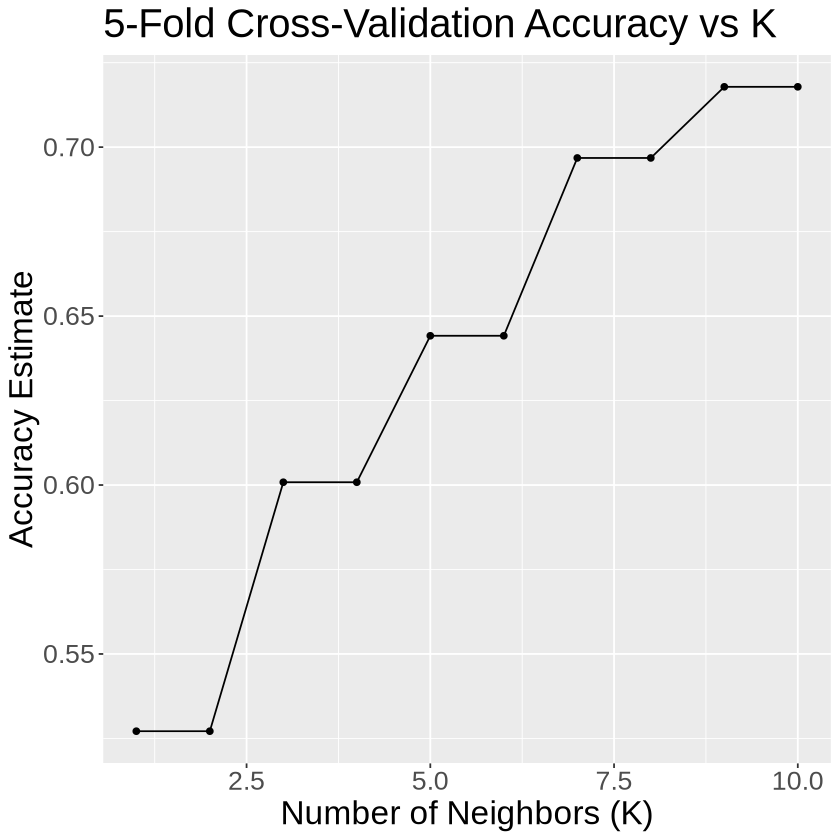

In [44]:
accuracies <- model_results |>
    filter(.metric == "accuracy")
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors (K)", y = "Accuracy Estimate") +
    ggtitle("5-Fold Cross-Validation Accuracy vs K") + 
    theme(text = element_text(size = 20))
accuracy_versus_k 

## Insights from the k-nearest neighbors (*k-NN*) Tuning Plot

The plot shows that the mean cross-validation accuracy from a 5-fold validation procedure across different values of **k** (number of neighbors). Based on the plot, the highest accuracy is achieved when **k** = 9 or 10 (~72%), indicating that these **k** values are the best for predicting the response variable (**subscribe**). As **k** increases from 1 to 10, the accuracy improves steadily where the standard error decreases as **k** increases, demonstrating greater stability and accuracy in model performance at higher **k** values. Overall, the model does answer the question that player characteristics and in-game behaviours are somewhat predictive of newsletter subscription. While a ~72% accuracy is a solid starting point, the model does make mistakes in predicting whether a player is subscribed to the newsletter, as seen in the confusion matrix, but there is room for improvement as a more complex method can improve accuracy. 


## Why is this method appropriate? 

k-nearest neighbors (*k-NN*) is a non-parametric, instance-based algorithm well-suited for classification questions. Given that we are dealing with and predicting categorical data (whether a player subscribes to a newsletter or not), *k-NN* works by comparing a new observation to a similar instance in the training set, making it effective when the relationships between the features and classes are non-linear or complex. *k-NN* makes little to no kinds of assumptions about the underlying data distribution (note: data is standardized), which is ideal in cases where we lack strong prior knowledge about how the predictors influence the outcome. Instead, it relies on a distance metric where it calculates the nearest neighbor from a certain point and makes a prediction based on proximity to similar cases in the data. This type of model is easy to implement and interpret, making it a valuable model for the classification question.  

## Assumptions of *k-NN*

While *k-NN* is non-parametric, the model must be scaled and center (otherwise known as standardized – mean is set to 0 and standard deviation is set to 1) to ensure that all predictors contribute equally to prediction of the observation. If the data is not standardized, the predictor with the broader variability will tend to dictate which neighbors are selected. This causes the unstandardized data to yield skewed results that are primarily based on the broader predictor instead of using all the predictors to make a meaningful prediction. Additionally, using this model with multiple irrelevant predictors will degrade the model’s performance. 


## Potential Limitations or Weaknesses

•	Without proper preprocessing (standardizing the data, removing zero-variance features, etc.) the model can make biased predictions, and this results in a lower performance

•	Using too many predictors can reduce accuracy as *k-NN* calculates distance to every point and as features increase, distances can become less meaningful

•	Using accuracy as the sole metric for evaluation the classifier does not account for the type of mistake the model makes 

## How did you compare and select the model? 

To assess how the model performance varies, I used a 5-fold cross-validation with a grid of **k** values from *1 to 10*. The tuning process was completed by utilizing the `tune_grid()` function, which was able to systematically evaluate each **k** value and return averaged metrics across folds. By filtering the evaluation metric for ‘accuracy’ and plotting this in a graph, I was able to select and visualize that a **k** value of 9 or 10 produced the highest performance (~72%). This allowed me to select the best model based on the highest cross-validated accuracy. 


Essentially, just put all of your discussions at the end of this and even include a link to your Git Hub respository just for a safety measure. As long as everything is clear, the format is fine. 

When submitting, save the file and run ALL of the cells beforehand. Save this to your computer and submit through gradescope!

## Discussion: Summary of Findings 
A k-nearest neighbors (k-NN) algorithm was used to classify whether the model accurately predicts if a player subscribes to a newsletter based on their demographic characteristics (experience, age, gender) and in-game behaviours (average session length and number of sessions). Once tuning for the most optimal number of neighbors (**k**) was completed, it was observed that both **k** = 9 and **k** = 10 produced the highest classification accuracy of roughly 72%, as shown in both the 5-fold cross-validation plot and table. The accuracy consistently improves with an increasing **k** value while eventually plateauing at **k** = 9. 



## Were these results expected?
Overall, these results were mostly aligned with my expectations given that player behaviour often correlates with user engagement levels (for instance, more frequent sessions or longer gaming playtime typically indicates that players have a stronger connection to the game and there’s a higher chance that they’ll subscribe to gaming newsletters). Something that I was anticipating was that there would be slightly more variation between the **k** values and possibly a shaper peak at a lower **k**, which did not occur. This demonstrates that the k values had a rather stable, but gradual improvement as the values increased. 


## Implications of the Findings
An accuracy of roughly 72% is modestly strong, suggesting that both behavioural and demographic features do provide informative signals for predicting player subscription status. This type of model can be of use for gaming studios to implement a targeted marketing strategy, as this can help identify potential subscribers. Additionally, these findings validate the idea that in-game engagement metrics are useful proxies for user interest and commitment. 


## Future Questions and Directions
These results open several new questions, such as, but not limited to: 

1.	Can we extend the model to predict whether users will unsubscribe in the future?


2.	Would other classification models (such as linear regression) outperform k-NN?


3.	Which specific variable(s) are the most predictive of subscribing?


4.	Do predictive patterns differ by gender or age group?


5.	Would additional behavioural signals (such as in-game purchases or achievements) improve the prediction accuracy? 


## References

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science. CRC Press. https://datasciencebook.ca/index.html

‌Simple value assignments for novel factor levels — step_novel. (2025). Tidymodels.org. https://recipes.tidymodels.org/reference/step_novel.html‌

Link to my project's GitHub repository: https://github.com/ljpajic/Dsci_100_Project